# Setup

In [ ]:
!pip install torchlens --quiet
!pip install rsatoolbox --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.0/656.0 kB 7.3 MB/s eta 0:00:00


In [ ]:
# @title Importing dependencies

from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io
import torchlens as tl
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm


In [ ]:
import logging
import matplotlib as mpl
mpl.set_loglevel("ERROR")

In [ ]:
# @title Figure settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# Download and Visualize Dataset

In [ ]:
# @markdown `download_mnist()`: Function to download MNIST.

def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output

      full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform
          )
      full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform
          )

  train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set,
      [train_prop * keep_prop, valid_prop * keep_prop, discard_prop]
      )
  test_set, _ = torch.utils.data.random_split(
      full_test_set,
      [keep_prop, discard_prop]
      )

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set

In [ ]:
train_set, valid_set, test_set = download_mnist()

100%|██████████| 4542/4542 [00:00<00:00, 2986444.39it/s]


Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


In [ ]:
#@markdown To get started exploring the dataset, here are a few plotting functions:

#@markdown `get_plotting_color()`: Returns a color for the specific dataset, e.g. "train" or model index.
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

# Basic MLP

In [ ]:
NUM_INPUTS = np.product(train_set.dataset.data[0].shape) # size of an MNIST image
NUM_OUTPUTS = 10 # number of MNIST classes

import torch.nn.functional as F

class Triangle(torch.nn.Module):
    r"""Applies the Sigmoid element-wise function:
    """

    def __init__(self,  power: float=1, inplace: bool = True):
        super(Triangle, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input):
        input = input - torch.mean(input.data, axis=1, keepdims=True)
        return F.relu(input, inplace=self.inplace) ** self.power

    def extra_repr(self) -> str:
        return 'power=%s'%self.power

class Softmax(torch.nn.Module):
    r"""Applies the Sigmoid element-wise function:
    """

    def __init__(self,  temperature: float=1):
        super(Softmax, self).__init__()
        self.temperature = temperature

    def forward(self, input):
        #input = input - torch.mean(input.data, axis=1, keepdims=True)
        return F.softmax(input/self.temperature, dim = 1)

    def extra_repr(self) -> str:
        return 'power=%s'%self.power

class RePU(torch.nn.Module):
    r"""Applies the Repu function element-wise:
    """

    def __init__(self, power = 2, inplace: bool = False):
        super(RePU, self).__init__()
        self.power = power
        self.inplace = inplace

    def forward(self, input):
        return F.relu(input, inplace=self.inplace)**self.power

    def extra_repr(self) -> str:
        return 'power=%s'%self.power

class MultiLayerPerceptron(torch.nn.Module):
  """
  Simple multilayer perceptron model class with one hidden layer.
  """

  def __init__(
      self,
      num_inputs=NUM_INPUTS,
      num_hidden=100,
      num_outputs=NUM_OUTPUTS,
      activation_type="sigmoid",
      temperature = None,
      bias=False,
      ):
    """
    Initializes a multilayer perceptron with a single hidden layer.

    Arguments:
    - num_inputs (int, optional): number of input units (i.e., image size)
    - num_hidden (int, optional): number of hidden units in the hidden layer
    - num_outputs (int, optional): number of output units (i.e., number of
      classes)
    - activation_type (str, optional): type of activation to use for the hidden
      layer ('sigmoid', 'tanh', 'relu' or 'linear')
    - bias (bool, optional): if True, each linear layer will have biases in
      addition to weights
    """


    super().__init__()

    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.activation_type = activation_type
    self.temperature = temperature
    self.bias = bias

    # default weights (and biases, if applicable) initialization is used
    # see https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/linear.py
    self.lin1 = torch.nn.Linear(num_inputs, num_hidden, bias=bias)
    self.lin2 = torch.nn.Linear(num_hidden, num_outputs, bias=bias)

    self._store_initial_weights_biases()

    self._set_activation() # activation on the hidden or output layer
    self.softmax = torch.nn.Softmax(dim=1) # activation on the output layer


  def _store_initial_weights_biases(self):
    """
    Stores a copy of the network's initial weights and biases.
    """

    self.init_lin1_weight = self.lin1.weight.data.clone()
    self.init_lin2_weight = self.lin2.weight.data.clone()
    if self.bias:
      self.init_lin1_bias = self.lin1.bias.data.clone()
      self.init_lin2_bias = self.lin2.bias.data.clone()

  def _set_activation(self):
    """
    Sets the activation function used for the hidden layer.
    """

    if self.activation_type.lower() == "sigmoid":
      self.activation = torch.nn.Sigmoid() # maps to [0, 1]
    elif self.activation_type.lower() == "tanh":
      self.activation = torch.nn.Tanh() # maps to [-1, 1]
    elif self.activation_type.lower() == "relu":
      self.activation = torch.nn.ReLU() # maps to positive
    elif self.activation_type.lower() == "identity":
      self.activation = torch.nn.Identity() # maps to same
    elif self.activation_type.lower() == "repu":
      self.activation = RePU()
    elif self.activation_type.lower() == "triangle":
      self.activation = Triangle()
    elif self.activation_type.lower() == "softmax":
      self.activation = Softmax(temperature = self.temperaature)
    else:
      raise NotImplementedError(
          f"{self.activation_type} activation type not recognized. Only "
          "'sigmoid', 'relu' and 'identity' have been implemented so far."
          )

  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets. This variable is not used
      here. However, it may be needed for other learning rules, to it is
      included as an argument here for compatibility.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred

  def forward_backprop(self, X):
    """
    Identical to forward(). Should not be overwritten when creating new
    child classes to implement other learning rules, as this method is used
    to compare the gradients calculated with other learning rules to those
    calculated with backprop.
    """

    h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
    y_pred = self.softmax(self.lin2(h))
    return y_pred


  def list_parameters(self):
    """
    Returns a list of model names for a gradient dictionary.

    Returns:
    - params_list (list): List of parameter names.
    """

    params_list = list()

    for layer_str in ["lin1", "lin2"]:
      params_list.append(f"{layer_str}_weight")
      if self.bias:
        params_list.append(f"{layer_str}_bias")

    return params_list


  def gather_gradient_dict(self):
    """
    Gathers a gradient dictionary for the model's parameters. Raises a
    runtime error if any parameters have no gradients.

    Returns:
    - gradient_dict (dict): A dictionary of gradients for each parameter.
    """

    params_list = self.list_parameters()

    gradient_dict = dict()
    for param_name in params_list:
      layer_str, param_str = param_name.split("_")
      layer = getattr(self, layer_str)
      grad = getattr(layer, param_str).grad
      if grad is None:
        raise RuntimeError("No gradient was computed")
      gradient_dict[param_name] = grad.detach().clone().numpy()

    return gradient_dict

# Basic Optimizer

In [ ]:
class BasicOptimizer(torch.optim.Optimizer):
  """
  Simple optimizer class based on the SGD optimizer.
  """
  def __init__(self, params, lr=0.01, weight_decay=0):
    """
    Initializes a basic optimizer object.

    Arguments:
    - params (generator): Generator for torch model parameters.
    - lr (float, optional): Learning rate.
    - weight_decay (float, optional): Weight decay.
    """

    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr}")
    if weight_decay < 0.0:
        raise ValueError(f"Invalid weight_decay value: {weight_decay}")

    defaults = dict(
        lr=lr,
        weight_decay=weight_decay,
        )

    super().__init__(params, defaults)

  def step(self):
      """
      Performs a single optimization step.
      """

      for group in self.param_groups:
        for p in group["params"]:

          # only update parameters with gradients
          if p.grad is not None:

            # apply weight decay to gradient, if applicable
            if group["weight_decay"] != 0:
              p.grad = p.grad.add(p, alpha=group["weight_decay"])

            # apply gradient-based update
            p.data.add_(p.grad, alpha=-group["lr"])

# Train Model

In [ ]:
#@markdown `train_model(MLP, train_loader, valid_loader, optimizer)`: Main function.
#@markdown Trains the model across epochs. Aggregates loss and accuracy statistics
#@markdown from the training and validation datasets into a results dictionary which is returned.
def train_model(MLP, train_loader, valid_loader, optimizer, num_epochs=5):
  """
  Train a model for several epochs.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - num_epochs (int, optional): Number of epochs to train model.

  Returns:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  """

  results_dict = {
      "avg_train_losses": list(),
      "avg_valid_losses": list(),
      "avg_train_accuracies": list(),
      "avg_valid_accuracies": list(),
  }

  for e in tqdm(range(num_epochs)):
    no_train = True if e == 0 else False # to get a baseline
    latest_epoch_results_dict = train_epoch(
        MLP, train_loader, valid_loader, optimizer=optimizer, no_train=no_train
        )

    for key, result in latest_epoch_results_dict.items():
      if key in results_dict.keys() and isinstance(results_dict[key], list):
        results_dict[key].append(latest_epoch_results_dict[key])
      else:
        results_dict[key] = result # copy latest

  return results_dict


def train_epoch(MLP, train_loader, valid_loader, optimizer, no_train=False):
  """
  Train a model for one epoch.

  Arguments:
  - MLP (torch model): Model to train.
  - train_loader (torch dataloader): Dataloader to use to train the model.
  - valid_loader (torch dataloader): Dataloader to use to validate the model.
  - optimizer (torch optimizer): Optimizer to use to update the model.
  - no_train (bool, optional): If True, the model is not trained for the
    current epoch. Allows a baseline (chance) performance to be computed in the
    first epoch before training starts.

  Returns:
  - epoch_results_dict (dict): Dictionary storing epoch results on training
    and validation data.
  """

  criterion = torch.nn.NLLLoss()

  epoch_results_dict = dict()
  for dataset in ["train", "valid"]:
    for sub_str in ["correct_by_class", "seen_by_class"]:
      epoch_results_dict[f"{dataset}_{sub_str}"] = {
          i:0 for i in range(MLP.num_outputs)
          }

  MLP.train()
  train_losses, train_acc = list(), list()
  for X, y in train_loader:
    y_pred = MLP(X, y=y)
    #print(f'predicted shape = {y_pred.shape}')
    #print(f'actual shape = {y.shape}')
    loss = criterion(torch.log(y_pred), y)
    acc = (torch.argmax(y_pred.detach(), axis=1) == y).sum() / len(y)
    train_losses.append(loss.item() * len(y))
    train_acc.append(acc.item() * len(y))
    update_results_by_class_in_place(
        y, y_pred.detach(), epoch_results_dict, dataset="train",
        num_classes=MLP.num_outputs
        )
    optimizer.zero_grad()
    if not no_train:
      loss.backward()
      optimizer.step()

  num_items = len(train_loader.dataset)
  epoch_results_dict["avg_train_losses"] = np.sum(train_losses) / num_items
  epoch_results_dict["avg_train_accuracies"] = np.sum(train_acc) / num_items * 100

  MLP.eval()
  valid_losses, valid_acc = list(), list()
  with torch.no_grad():
    for X, y in valid_loader:
      y_pred = MLP(X)
      loss = criterion(torch.log(y_pred), y)
      acc = (torch.argmax(y_pred, axis=1) == y).sum() / len(y)
      valid_losses.append(loss.item() * len(y))
      valid_acc.append(acc.item() * len(y))
      update_results_by_class_in_place(
          y, y_pred.detach(), epoch_results_dict, dataset="valid"
          )

  num_items = len(valid_loader.dataset)
  epoch_results_dict["avg_valid_losses"] = np.sum(valid_losses) / num_items
  epoch_results_dict["avg_valid_accuracies"] = np.sum(valid_acc) / num_items * 100

  return epoch_results_dict


def update_results_by_class_in_place(y, y_pred, result_dict, dataset="train",
                                     num_classes=10):
  """
  Updates results dictionary in place during a training epoch by adding data
  needed to compute the accuracies for each class.

  Arguments:
  - y (torch Tensor): target labels
  - y_pred (torch Tensor): predicted targets
  - result_dict (dict): Dictionary storing epoch results on training
    and validation data.
  - dataset (str, optional): Dataset for which results are being added.
  - num_classes (int, optional): Number of classes.
  """

  correct_by_class = None
  seen_by_class = None

  y_pred = np.argmax(y_pred, axis=1)
  if len(y) != len(y_pred):
    raise RuntimeError("Number of predictions does not match number of targets.")

  for i in result_dict[f"{dataset}_seen_by_class"].keys():
    idxs = np.where(y == int(i))[0]
    result_dict[f"{dataset}_seen_by_class"][int(i)] += len(idxs)

    num_correct = int(sum(y[idxs] == y_pred[idxs]))
    result_dict[f"{dataset}_correct_by_class"][int(i)] += num_correct

# Inspect Model Performance

In [ ]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

# Hebbian Learning

In [ ]:
class HebbianFunction(torch.autograd.Function):
  """
  Gradient computing function class for Hebbian learning.
  """

  @staticmethod
  def forward(context, input, weight, bias=None, nonlinearity=None, target=None):
    """
    Forward pass method for the layer. Computes the output of the layer and
    stores variables needed for the backward pass.

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - output (torch tensor): layer output.
    """

    # compute the output for the layer (linear layer with non-linearity)
    output = input.mm(weight.t())
    if bias is not None:
      output += bias.unsqueeze(0).expand_as(output)
    if nonlinearity is not None:
      output = nonlinearity(output)

    # calculate the output to use for the backward pass
    output_for_update = output if target is None else target

    # store variables in the context for the backward pass
    context.save_for_backward(input, weight, bias, output_for_update)

    return output

  @staticmethod
  def backward(context, grad_output=None):
    """
    Backward pass method for the layer. Computes and returns the gradients for
    all variables passed to forward (returning None if not applicable).

    Arguments:
    - context (torch context): context in which variables can be stored for
      the backward pass.
    - input (torch tensor): input to the layer.
    - weight (torch tensor): layer weights.
    - bias (torch tensor, optional): layer biases.
    - nonlinearity (torch functional, optional): nonlinearity for the layer.
    - target (torch tensor, optional): layer target, if applicable.

    Returns:
    - grad_input (None): gradients for the input (None, since gradients are not
      backpropagated in Hebbian learning).
    - grad_weight (torch tensor): gradients for the weights.
    - grad_bias (torch tensor or None): gradients for the biases, if they aren't
      None.
    - grad_nonlinearity (None): gradients for the nonlinearity (None, since
      gradients do not apply to the non-linearities).
    - grad_target (None): gradients for the targets (None, since
      gradients do not apply to the targets).
    """

    input, weight, bias, output_for_update = context.saved_tensors
    grad_input = None
    grad_weight = None
    grad_bias = None
    grad_nonlinearity = None
    grad_target = None

    input_needs_grad = context.needs_input_grad[0]
    if input_needs_grad:
      pass

    weight_needs_grad = context.needs_input_grad[1]
    if weight_needs_grad:
      grad_weight = output_for_update.t().mm(input)
      grad_weight = grad_weight / len(input) # average across batch

      # center around 0
      #grad_weight = grad_weight - grad_weight.mean(axis=0) # center around 0

      ## or apply Oja's rule (not compatible with clamping outputs to the targets!)
      # oja_subtract = output_for_update.pow(2).mm(grad_weight).mean(axis=0)
      # grad_weight = grad_weight - oja_subtract

      # take the negative, as the gradient will be subtracted
      grad_weight = -grad_weight

    if bias is not None:
      bias_needs_grad = context.needs_input_grad[2]
      if bias_needs_grad:
        grad_bias = output_for_update.mean(axis=0) # average across batch

        # center around 0
        grad_bias = grad_bias - grad_bias.mean()

        ## or apply an adaptation of Oja's rule for biases
        ## (not compatible with clamping outputs to the targets!)
        # oja_subtract = (output_for_update.pow(2) * bias).mean(axis=0)
        # grad_bias = grad_bias - oja_subtract

        # take the negative, as the gradient will be subtracted
        grad_bias = -grad_bias

    return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target

In [ ]:
class SoftHebbianFunction(torch.autograd.Function):
  """
  Gradient computing function class for Soft Hebbian learning.
  """

  @staticmethod
  def forward(context, input, weight, bias=None, softmax_temp=1, target=None):
    # normalize

    # pre activation
    pre_act = input.mm(weight.t()) #u
    if bias is not None:
      pre_act += bias.unsqueeze(0).expand_as(u) #pre act

    # softmax of pre activation
    output = F.softmax(pre_act/softmax_temp, dim = 1)

    # calculate the output to use for the backward pass
    output_for_update = output if target is None else target

    # store variables in the context for the backward pass
    context.save_for_backward(input, weight, bias, pre_act, output_for_update)

    return output

  @staticmethod
  def backward(context, grad_output=None):

    input, weight, bias, pre_act, output_for_update = context.saved_tensors
    grad_input = None
    grad_weight = None
    grad_bias = None
    grad_nonlinearity = None
    grad_target = None

    input_needs_grad = context.needs_input_grad[0]
    if input_needs_grad:
      pass

    max_idx = torch.argmax(output_for_update, dim = 1)

    weight_needs_grad = context.needs_input_grad[1]
    if weight_needs_grad:
      u_w = pre_act.unsqueeze(2) * weight.unsqueeze(0)
      input_sum = input.sum(dim=0)
      output_sum = output_for_update.sum(dim=0)
      grad_weight = output_sum.unsqueeze(1) * (input_sum - u_w)
      grad_weight = grad_weight / len(input) # average across batch


      # Negate grad_weight only where the mask is True
      #grad_weight = -grad_weight
      for i in range(grad_weight.shape[0]):
        grad_weight[i, max_idx[i], :] = -grad_weight[i, max_idx[i], :]

    if bias is not None:
      bias_needs_grad = context.needs_input_grad[2]
      if bias_needs_grad:
        grad_bias = output_for_update.mean(axis=0) # average across batch

        # center around 0
        grad_bias = grad_bias - grad_bias.mean()

        grad_bias = -grad_bias

    return grad_input, grad_weight, grad_bias, grad_nonlinearity, grad_target

In [ ]:
class HebbianMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output

    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """
    #print("Applying Hebbian Update to Hidden Layer")
    h = HebbianFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation,
        self.temperature
    )

    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    #print("Applying Hebbian Update to Output Layer")
    y_pred = HebbianFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax,
        targets
    )

    return y_pred

In [ ]:
class SoftHebbianMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, softmax_temp = 1, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output
    self.softmax_temp = softmax_temp

    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """
    #print("Applying Hebbian Update to Hidden Layer")
    h = SoftHebbianFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.softmax_temp,
    )

    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    #print("Applying Hebbian Update to Output Layer")
    y_pred = SoftHebbianFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax_temp,
        targets
    )

    return y_pred

In [ ]:
class TanhSoftHebbianMultiLayerPerceptron(MultiLayerPerceptron):
  """
  Hebbian multilayer perceptron with one hidden layer.
  """

  def __init__(self, clamp_output=True, softmax_temp = 1, **kwargs):
    """
    Initializes a Hebbian multilayer perceptron object

    Arguments:
    - clamp_output (bool, optional): if True, outputs are clamped to targets,
      if available, when computing weight updates.
    """

    self.clamp_output = clamp_output
    self.softmax_temp = softmax_temp

    super().__init__(**kwargs)


  def forward(self, X, y=None):
    """
    Runs a forward pass through the network.

    Arguments:
    - X (torch.Tensor): Batch of input images.
    - y (torch.Tensor, optional): Batch of targets, stored for the backward
      pass to compute the gradients for the last layer.

    Returns:
    - y_pred (torch.Tensor): Predicted targets.
    """
    #print("Applying Hebbian Update to Hidden Layer")
    h = HebbianFunction.apply(
        X.reshape(-1, self.num_inputs),
        self.lin1.weight,
        self.lin1.bias,
        self.activation
    )

    # if targets are provided, they can be used instead of the last layer's
    # output to train the last layer.
    if y is None or not self.clamp_output:
      targets = None
    else:
      targets = torch.nn.functional.one_hot(
          y, num_classes=self.num_outputs
          ).float()

    #print("Applying Hebbian Update to Output Layer")
    y_pred = SoftHebbianFunction.apply(
        h,
        self.lin2.weight,
        self.lin2.bias,
        self.softmax_temp,
        targets
    )

    return y_pred

# Simplify Task

In [ ]:
#@markdown The following function returns a dataset restricted to specific classes:

#@markdown `restrict_classes(dataset)`: Keeps specified classes in a dataset.

def restrict_classes(dataset, classes=[6], keep=True):
  """
  Removes or keeps specified classes in a dataset.

  Arguments:
  - dataset (torch dataset or subset): Dataset with class targets.
  - classes (list): List of classes to keep or remove.
  - keep (bool): If True, the classes specified are kept. If False, they are
  removed.

  Returns:
  - new_dataset (torch dataset or subset): Datset restricted as specified.
  """

  if hasattr(dataset, "dataset"):
    indices = np.asarray(dataset.indices)
    targets = dataset.dataset.targets[indices]
    dataset = dataset.dataset
  else:
    indices = np.arange(len(dataset))
    targets = dataset.targets

  specified_idxs = np.isin(targets, np.asarray(classes))
  if keep:
    retain_indices = indices[specified_idxs]
  else:
    retain_indices = indices[~specified_idxs]

  new_dataset = torch.utils.data.Subset(dataset, retain_indices)

  return new_dataset

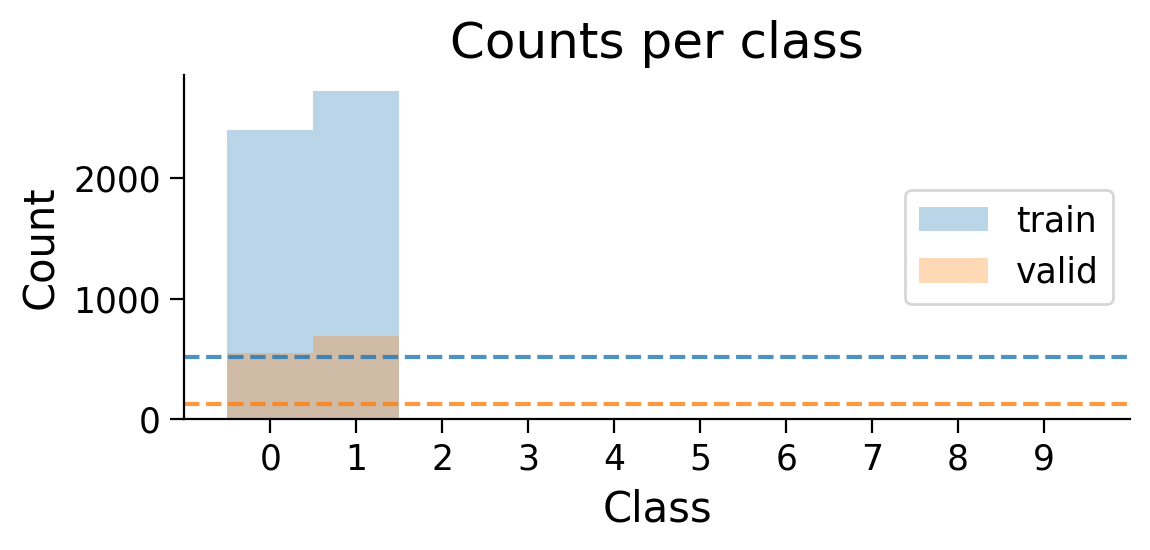

In [ ]:
BATCH_SIZE = 32

train_set_new = restrict_classes(train_set, [0, 1])
valid_set_new = restrict_classes(valid_set, [0, 1])

plot_class_distribution(train_set_new, valid_set_new)

train_loader_new = torch.utils.data.DataLoader(train_set_new, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_new = torch.utils.data.DataLoader(valid_set_new, batch_size=BATCH_SIZE, shuffle=False)

# Training

In [ ]:
NUM_HIDDEN = 100
HEBB_LR = 1e-6

HebbianMLP = TanhSoftHebbianMultiLayerPerceptron(
    num_hidden=NUM_HIDDEN,
    num_outputs=2,
    clamp_output=True,
    softmax_temp = 0.01,
    activation_type="tanh"
)

Hebb_optimizer = BasicOptimizer(HebbianMLP.parameters(), lr=HEBB_LR)

Hebb_results_dict = train_model(
    HebbianMLP,
    train_loader_new,
    valid_loader_new,
    Hebb_optimizer,
    num_epochs=10
    );

plot_results(Hebb_results_dict, num_classes=2)
plot_scores_per_class(Hebb_results_dict, num_classes=2)
plot_examples(valid_loader_new.dataset, MLP=HebbianMLP, num_classes=2)
plot_weights(HebbianMLP);

In [ ]:
print(Hebb_results_dict)

{'avg_train_losses': [11.298114305725335, 11.775495582735296, inf, inf, inf, inf, inf, inf, inf, inf], 'avg_valid_losses': [10.513197619140772, 11.407151344416125, 12.683666412144492, 14.804633334987496, inf, inf, inf, inf, inf, inf], 'avg_train_accuracies': [53.958658346333856, 53.958658346333856, 54.36817472698908, 54.11466458658346, 53.97815912636506, 53.25663026521062, 53.2176287051482, 53.10062402496099, 53.29563182527301, 53.315132605304214], 'avg_valid_accuracies': [55.35858176726664, 56.16438354003055, 56.56728440960216, 56.80902494143133, 56.2449637004966, 56.325543920999564, 56.16438356644679, 55.68090250278844, 55.68090250278844, 55.68090250278844], 'train_correct_by_class': {0: 22, 1: 2712}, 'train_seen_by_class': {0: 2404, 1: 2724}, 'valid_correct_by_class': {0: 1, 1: 690}, 'valid_seen_by_class': {0: 551, 1: 690}}
